<a href="https://colab.research.google.com/github/jeekyung/ESAA/blob/main/ESAA_OB_week15_%ED%8C%8C%EC%9D%B4%EC%8D%AC_%EB%94%A5%EB%9F%AC%EB%8B%9D_%ED%85%90%EC%84%9C%ED%94%8C%EB%A1%9C_ch4_4~5_pg_182~211.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **04 위성 이미지 분류**
---

### **4-1 텐서플로 데이터세트 로드**
---

>텐서플로 데이터셋 중 인공위성에서 지표면을 촬영한 이미지와 토지이용분류 값이 정리되어 있는 EuroSAT 데이터셋 불러오기
* 총 27000장의 위성 사진과 10개의 토지이용분류 값이 매칭되어 제공됨

In [48]:
import tensorflow as tf
import numpy as np
import json
import matplotlib.pylab as plt

# Tensorflow Datasets 활용
import tensorflow_datasets as tfds

In [49]:
# EuroSAT 위성 사진 데이터셋 로드
DATA_DIR= "dataset/"

(train_ds, valid_ds), info = tfds.load('eurosat/rgb',split=['train[:80%]','train[80%:]'],
                                       shuffle_files=True,
                                       as_supervised=True,
                                       with_info=True,
                                       data_dir=DATA_DIR)
print(train_ds)
print(valid_ds)

<PrefetchDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


In [50]:
# 메타 데이터 확인
print(info)

tfds.core.DatasetInfo(
    name='eurosat',
    full_name='eurosat/rgb/2.0.0',
    description="""
    EuroSAT dataset is based on Sentinel-2 satellite images covering 13 spectral
    bands and consisting of 10 classes with 27000 labeled and
    geo-referenced samples.
    
    Two datasets are offered:
    - rgb: Contains only the optical R, G, B frequency bands encoded as JPEG image.
    - all: Contains all 13 bands in the original value range (float32).
    
    URL: https://github.com/phelber/eurosat
    """,
    config_description="""
    Sentinel-2 RGB channels
    """,
    homepage='https://github.com/phelber/eurosat',
    data_path='dataset/eurosat/rgb/2.0.0',
    file_format=tfrecord,
    download_size=89.91 MiB,
    dataset_size=89.50 MiB,
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(64, 64, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    supervised_keys=('

* EuroSAT 데이터세트의 2가지 유형 중 JPEG 이미지로 인코딩한 RGB 데이터세트 다운받은 상태

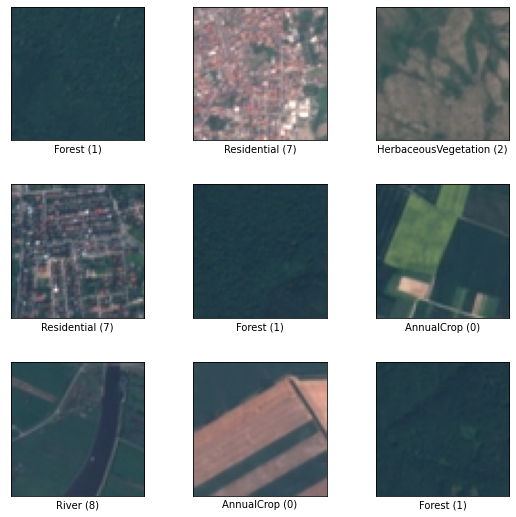

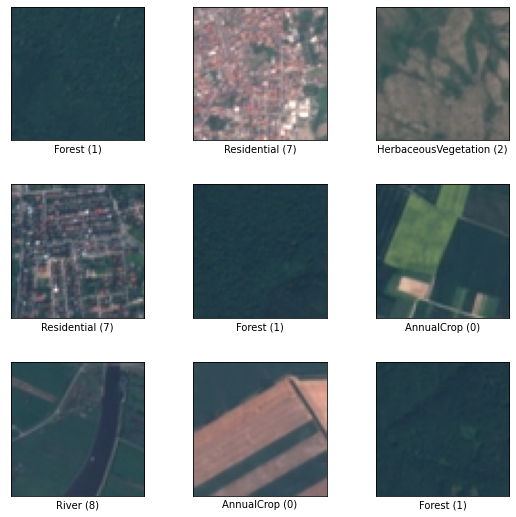

In [51]:
# 데이터 확인
tfds.show_examples(train_ds,info)

,image,label
0,,5 (Pasture)
1,,7 (Residential)
2,,0 (AnnualCrop)
3,,1 (Forest)
4,,0 (AnnualCrop)
5,,2 (HerbaceousVegetation)
6,,9 (SeaLake)
7,,8 (River)
8,,2 (HerbaceousVegetation)
9,,9 (SeaLake)

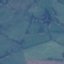
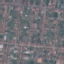
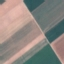
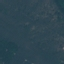
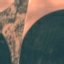
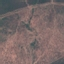
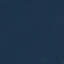
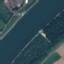
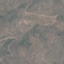
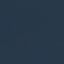

In [52]:
# as_dataframe 사용하여 샘플 출력
tfds.as_dataframe(valid_ds.take(10),info)

In [53]:
# 목표 클래스의 개수
NUM_CLASSES = info.features["label"].num_classes
print(NUM_CLASSES)

10


In [54]:
# 숫자 레이블을 활용해 문자열 메타 데이터로 변환
print(info.features["label"].int2str(6))

PermanentCrop


### **4-2 데이터 전처리**
---

>텐서플로 데이터세트 사용 시:
* 딥러닝 학습에 필요한 데이터 데이터세트를 쉽게 구할 수 있음
* 전처리 과정이 매우 쉬움

>텐서플로 연산은 float32 숫자 값을 사용하기 때문에, cats 함수를 사용하여 자료형을 foat32로 변환해줌.<br/>
입력 이미지는 0~255 범위의 픽셀 값을 갖기 때문에 255로 나눠 정규화.

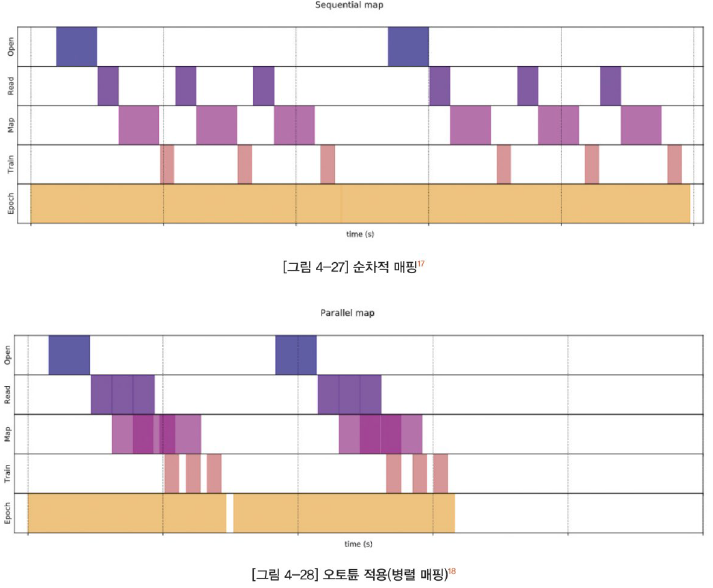

* 오토튠을 적용하지 않으면 데이터를 읽어서 매핑하고 훈련하는 과정을 순차적으로 처리하기 때문에 시간이 오래 걸림
* 반면 오토튠을 적용하면 하드웨어 리소스를 병렬로 매핑하여 처리하기 때문에 같은 작업을 훨씬 짧은 시간에 처리할 수 있게 됨

>* 정규화 변환을 마친 데이터세트에 shuffle() 메소드를 적용하면 순서를 랜덤하게 섞어줌.<br/>
모델의 일반화된 성능을 높이기 위해 훈련 데이터세트에서 미니 배치를 생성할 때 입력 순서에 무작위성 부여
* prefetch() 메소드는 모델이 훈련을 진행하는 동안 다음에 입력할 데이터를 불러와서 미리 전처리를 하도록 시스템 조율. 병렬 처리를 통해 모델 훈련 시간을 단축시킴.

In [55]:
# 데이터 전처리 파이프라인 
BATCH_SIZE = 64
BUFFER_SIZE = 1000

def preprocess_data(image, label):
    image = tf.cast(image, tf.float32) / 255.   # 0~1 정규화, float32 변환
    return image, label

train_data = train_ds.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)
valid_data = valid_ds.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)

train_data = train_data.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_data = valid_data.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE) 

### **4-3 모델 훈련 및 검증**
---

* 배치 정규화, 합성곱, 풀링 레이어로 구성된 유닛을 2개 연결하고, Dense 레이어와 Dropout으로 구성된 최종 분류기를 갖는 딥러닝 모델을 Sequential API로 생성

In [56]:
# Sequential API를 사용하여 샘플 모델 생성
def build_model():

    model = tf.keras.Sequential([

        # Convolution 층 
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),

        # Classifier 출력층 
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'), 
        tf.keras.layers.Dropout(0.3),  
        tf.keras.layers.Dense(64, activation='relu'), 
        tf.keras.layers.Dropout(0.3),              
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax'),
    ])

    return model

model = build_model()

In [ ]:
# 예측 클래스가 10개인 다중 분류 문제에 맞게 손실함수와 평가지표를 설정,
# 모델을 50개 epoch 훈련

# 모델 컴파일
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 모델 훈련
history = model.fit(train_data, 
                    validation_data=valid_data, 
                    epochs=10) 

Epoch 1/10
 32/338 [=>............................] - ETA: 1:50 - loss: 2.3589 - accuracy: 0.2607

In [ ]:
# 모델 훈련 단계에서 훈련 결과를 저장해 둔 history 객체.
def plot_loss_acc(history, epoch):

  loss, val_loss = history.history['loss'], history.history['val_loss']
  acc, val_acc = history.history['accuracy'], history.history['val_accuracy']

  fig, axes = plt.subplots(1,2,figsize=(12,4))

  axes[0].plot(range(1, epoch + 1), loss, label='Training')
  axes[0].plot(range(1, epoch + 1), val_loss, label='Validation')
  axes[0].legend(loc='best')
  axes[0].set_title('Loss')

  axes[1].plot(range(1, epoch + 1), acc, label='Training')
  axes[1].plot(range(1, epoch + 1), val_acc, label='Validation')
  axes[1].legend(loc='best')
  axes[1].set_title('Accuracy')

  plt.show()

In [ ]:
# 손실함수, 정확도 그래프 그리기
plot_loss_acc(history,50)

* 모델은 10 epoch까지는 빠른 속도로 훈련이 진행되면서 손실함수가 급격하게 감소함.
* 그러나 그 이후로는 검증 세트에 대한 손실함수가 더 이상 줄어들지 않으면서 과대적합 경향을 나타냄

### **4-4 데이터 증강(Data Augmentation)**
---

>앞서 배운 과대적합을 해소하는 기법인 배치 정규화, Dropout 등을 적용했음에도 과대적합 발생함.<br/>
-->이미지 분류 문제에서 과대적합을 해소하고 모델의 일반화된 Robust한 성능을 확보하는 기법으로 데이터 증강(Data Augmentation) 기법 적용<br/>
: 이미지 데이터에 여러 가지 변형을 주어 훈련 데이터의 다양성을 확보하는 방식으로, 모델이 새로운 데이터에 대한 예측력을 강화하도록 하는 개념

In [ ]:
# 샘플 이미지 선택하여 시각화
image_batch, label_batch = next(iter(train_data.take(1)))

image = image_batch[0]
label = label_batch[0].numpy()

plt.imshow(image)
plt.title(info.features["label"].int2str(label))

In [ ]:
# 샘플 이미지에 변화를 주기 전과 후의 이미지를 비교할 수 있는 시각화 함수 정의
def plot_augmentation(original, augmented):

  fig,axes = plt.subplots(1,2,figsize=(12,4))

  axes[0].imshow(original)
  axes[0].set_title('Original')

  axes[1].imshow(augmented)
  axes[1].set_title('Augmented')

  plt.show()

In [ ]:
# 좌우 뒤집기
lr_flip = tf.image.flip_left_right(image)
plot_augmentation(image, lr_flip)

In [ ]:
# 상하 뒤집기
ud_flip = tf.image.flip_up_down(image)
plot_augmentation(image, ud_flip)

In [ ]:
# 회전
rotate90 = tf.image.rot90(image)
plot_augmentation(image, rotate90)

In [ ]:
# transpose
transpose = tf.image.transpose(image)
plot_augmentation(image, transpose)

In [ ]:
# 이미지 자르기 1 - 이미지의 중심에서 일정 부분을 잘라내는 방법
crop1 = tf.image.central_crop(image, central_fraction=0.6)
plot_augmentation(image,crop1)

In [ ]:
# 이미지 자르기 2 - 상하좌우 랜덤한 방향으로 shift 이동
img = tf.image.resize_with_crop_or_pad(image, 64 + 20, 64 + 20) # 사이즈 키우기
crop2 = tf.image.random_crop(img, size=[64,64,3])
plot_augmentation(image,crop2)

In [ ]:
# 이미지 밝기 조정
brightness = tf.image.adjust_brightness(image,delta=0.3)
plot_augmentation(image,brightness)

In [ ]:
# 이미지의 채도 변경
saturation = tf.image.adjust_saturation(image,saturation_factor=0.5)
plot_augmentation(image,saturation)

In [ ]:
# 이미지 대비 조정
contrast = tf.image.adjust_contrast(image,contrast_factor=2)
plot_augmentation(image,contrast)

* 앞서 다룬 여러 기법 중에서 몇가지를 선택하여 데이터 증강 및 전처리를 수행하는 data_augmentation 사용자 함수 정의

In [ ]:
# 이미지 증강 전처리
def data_augmentation(image,label):

  image = tf.image.random_flip_left_right(image)  #좌우 반전
  image = tf.image.random_flip_up_down(image)  #상하 반적
  image = tf.image.random_brightness(image,max_delta=0.3)  #밝기 변화
  image = tf.image.random_crop(image,size=[64,64,3])

  image = tf.cast(image,tf.float32)/255.  #0~1 정규화

  return image,label

train_aug = train_ds.map(data_augmentation, num_parallel_calls=tf.data.AUTOTUNE)
valid_aug = valid_ds.map(data_augmentation, num_parallel_calls=tf.data.AUTOTUNE)

train_aug = train_aug.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_aug = valid_aug.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

print(train_aug)
print(valid_aug)

In [ ]:
# 모델 생성
aug_model = build_model()

# 모델 컴파일
aug_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

# 모델 훈련
aug_history = aug_model.fit(train_aug,
                            validation_data=valid_aug,
                            epochs=50)

* 데이터 증강을 하기 전과 모델의 성능 자체는 큰 차이가 없음

In [ ]:
# 손실함수, 정확도 그래프 그리기
plot_loss_acc(aug_history, 50)

### **4-5 ResNet 사전 학습 모델**
---

>ResNet 모델:
* 우수한 성능.
* 사전에 방대한 이미지로 훈련을 받은 딥러닝 모델의 구조와 가중치를 그대로 가져오고,<br/>
모델의 끝단에 위치하는 Top 층에 위성 이미지를 분류할 수 있는 최종 분류기를 추가하는 방식으로 모델을 구성함.
* 이런 방식으로 딥러닝 모델을 구성하는 것을 전이학습이라고 부름

In [ ]:
!pip install wrappers

In [ ]:
# Pre-trained 모델을 사전 학습된 가중치와 함께 가져오기
from tensorflow.keras.applications import ResNet50V2

pre_trained_base = ResNet50V2(include_top=False,
                              weights='imagenet',
                              input_shape=[64,64,3])

# 사전 학습된 가중치를 업데이트 되지 않도록 설정
pre_trained_base.trainable =False

# 모델 구조 시각화
from tensorflow.python.keras.utils.vis_utils import plot_model
plot_model(pre_trained_base, show_shapes=True, show_layer_names=True, to_file='resnet50.png')

In [ ]:
# Top 층에 Classifier 추가
def build_trainsfer_classifier():
  model = tf.keras.Sequential([
      
      # Pre-trained Base
      pre_trained_base,
      # Classifier 출력층
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128,activation='relu'),
      tf.keras.layers.Dropout(0,3),
      tf.keras.layers.Dense(64,activation='relu'),
      tf.keras.layers.Dropout(0,3),
      tf.keras.layers.Dense(NUM_CLASSES,activation='softmax'),
  ])

  return model

# 모델 구조
tc_model = build_trainsfer_classifier()
tc_model.summary()

## **05 개/고양이 분류**
---

### **5-1 분석 준비**
---

#### **5-1-1 데이터셋 다운로드**

#### **5-1-2 라이브러리 불러오기**

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pylab as plt

In [ ]:
# 모델 컴파일
to_model_compile(optimizer='adam', loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])

# 모델 훈련
tc_history = tc_model.fit(train_aug,
                          validation_data=valid_aug,
                          epochs=50)

In [ ]:
# 손실함수, 정확도 그래프 그리기
plot_loss_acc(tc_history,50)

* 훈련 초기부터 검증 세트에 대한 정확도가 80% 이상.<br>
즉, 사전 학습 모델인 ResNet 모델의 가중치를 그대로 사용하여 새로운 데이터가 입력돼도 이미지로부터 피처를 빠르게 추출함.

In [ ]:
# 구글 드라이브 폴더 마운트
from google.colab import drive
drive.mount("/content/drive")

In [ ]:
# 압축 파일 해체
drive_path = "/content/drive/MyDrive/"
source_filename = drive_path + "cat-and-dog.zip.zip"

extract_folder = "dataset/"  #코랩 환경에 임시저장

import shutil
shutil.unpack_archive(source_filename, extract_folder)

In [ ]:
# 훈련 세트, 검증 세트 저장 위치 지정
train_dir = extract_folder + "archive/training_set/training_set"
valid_dir = extract_folder + "archive/test_set/test_set"
print(train_dir)
print(valid_dir)

### **5-2 모델 학습**
---

#### 5-2-1 ImageDataGenerator

* 케라스 ImageDataGenerator 클래스 함수를 실행하고 rescale 옵션을 지정해 이미지 각 픽셀의 값을 0~1 범위로 정규화.

In [ ]:
# 이미지 데이터 제너레이터 정의(Augmentation 미적용)
image_gen = ImageDataGenerator(rescale=(1/255.))
image_gen

#### 5-2-2 flow_From_directory 함수

* 저장한 폴더에서 이미지를 가져와 반복 이터레이션이 가능하도록 데이터세트 처리
* 훈련 세트가 저장되어있는 train_dir, batch_size 속성에는 배치를 구성하는 이미지 개수,<br/>target_size 속성에는 저장될 이미지의 (세로,가로) 픽셀 사이즈, <br/>class 속성에는 클래스 레이블, <br/>class_mode에는 이진 분류 문제를 나타내는 'banary' 모드, 랜덤 시드 값 지정

In [ ]:
# flow_from_directory 함수로 폴더에서 이미지를 가져와 제너레이터 객체로 정리
train_gen = image_gen.flow_from_directory(train_dir,
                                           batch_size=32,
                                           target_size=(224,224),
                                           classes=['cats','dogs'],
                                           seed=2020)
valid_gen = image_gen.flow_from_directory(valid_dir,
                                          batch_size=32,
                                          target_size=(224,224),
                                          classes=['cats','dogs'],
                                          class_mode='binary',
                                          seed=2020)

In [ ]:
# 1개의 샘플 이미지 선택 및 출력
class_labels=['cats','dogs']
batch = next(train_gen)
images,labels=batch[0],batch[1]

plt.figure(figsize=(16,8))
for i in range(32):
  ax = plt.subplot(4,8,i+1)
  plt.imshow(images[i])
  plt.title(class_labels[labels[i].astype(np.int)])
  plt.axis("off")
plt.tight_layout()
plt.show()

#### 5-2-3 모델 훈련

* 이진 분류 모델 정의. '배치 정규화-합성곱-풀링'으로 구성된 단위블럭을 3개 반복하여 이미지로부터 다양한 피처를 추출하고, 최종 분류기로는 Dense 레이어 사용<br/>
최종 출력 레이어는 노드 1개를 갖고 활성화 함수로 'sigmoid' 적용

In [ ]:
# Sequential API를 사용하여 샘플 모델 생성
def build_model():

  model = tf.keras.Sequential([
      
      #Convolution 층
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(32,(3,3), padding='same', activation='relu'),
      tf.keras.layers.MaxPooling2D((2,2)),

      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(64,(3,3),padding='same',activation='relu'),
      tf.keras.layers.MaxPooling2D((2,2)),

      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(128,(3,3),padding='same',activation='relu'),
      tf.keras.layers.MaxPooling2D((2,2)),

      # Classifier 출력층
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(256, activation='relu'),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(1,activation='sigmoid'),
  ])

  return model

model=build_model()

In [ ]:
# 모델 컴파일
model.compile(optimizer=tf.optimizers.Adam(lr=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(From_logits=True),
              metrics=['accuracy'])

# 모델 훈련
history = model.fit(train_gen,validation_data=valid_gen, epochs=20)

In [ ]:
# 손실함수, 정확도 그래프 그리기
plot_loss_acc(history,20)

#### 5-2-4 데이터 증강

* 좌우 방향 뒤집는 horizontal_flip 속성 지정, 회전은 최대 30도로 지정.
* 반시계 방향 변형하는 shear_range 속성과 줌으로 확대하는 zoom_range 속성 추가

In [ ]:
# 이미지 데이터 제너레이터 정의(Augmentation 적용)
image_gen_aug = ImageDataGenerator(rescale=1/255,
                                   horizontal_flip=True,
                                   rotation_range=30,
                                   shear_range=0.15,
                                   zoom_range=0.3)

#flow_from_directory 함수로 폴더에서 이미지 가져와서 제너레이터 객체로 정리
train_gen_aug = image_gen_aug.flow_from_directory(train_dir,
                                                  batch_size=32,
                                                  target_size=(224,224),
                                                  classes=['cats','dogs'],
                                                  class_mode='binary',
                                                  seed=2020)

valid_gen_aug = image_gen_aug.flow_from_directory(valid_dir,
                                                  batch_size=32,
                                                  target_size=(224,224),
                                                  classes=['cats','dogs'],
                                                  class_mode = 'binary',
                                                  seed=2020)

# 모델 생성
model_aug = build_model()

# 모델 컴파일
model.compile(optimizer=tf.optimizers.Adam(lr=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(From_logits=True),
              metrics=['accuracy'])

# 모델 훈련
history = model.fit(train_gen_aug,validation_data=valid_gen_aug, epochs=40)

In [ ]:
# 손실함수, 정확도 그래프 그리기
plot_loss_acc(history_aug,20)

* 과대적합 혹은 과소적합이 거의 발생하지 않고 학습이 잘 진행됨 확인.